## <font color=green> 1. Setup <a name="setup"></a></font> ##

### Import libraries and load the dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import asarray

dementia_data = pd.read_csv("data/dementia_data_cleaned_v2.csv", delimiter=",")

## <font color=green> 5. Making the model </font> ##

In [2]:
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.ensemble import VotingClassifier
import xgboost as xgb

from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

### 5.1 Selecting target features ###

In [3]:
NUMBER_OF_FEATURES = 13
corr = dementia_data.drop('dementia_all', axis=1).corrwith(dementia_data.dementia_all).abs().sort_values(ascending=False)
n_features = corr.head(NUMBER_OF_FEATURES)
model_features = n_features.index.to_numpy()

X = dementia_data[model_features]
y = dementia_data['dementia_all'].values
X

,SVD Amended Score,SVD Simple Score,lac_count,age,Global,EF,lacunes_num,PS,Fazekas,fazekas_cat,CMB_count,diabetes,hypertension
0,7.0,3.0,5,52.67,-1.287000,-2.403333,1,-1.290000,3,1,1,0,1
1,3.0,2.0,1,64.58,0.744000,1.280000,1,0.360000,1,0,1,0,1
2,2.0,1.0,1,74.92,-0.922000,-1.440000,1,-1.520000,1,0,0,0,1
3,4.0,2.0,3,74.83,-1.301102,-0.063088,1,-2.136271,2,1,0,0,1
4,3.0,2.0,1,79.25,-0.924000,-0.920000,1,-1.493333,2,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,0.0,0.0,0,67.00,-0.260000,-0.100000,0,-0.020000,0,0,0,0,1
1838,0.0,0.0,0,71.00,-1.003333,-0.370000,0,-1.060000,1,0,0,0,1
1839,0.0,0.0,0,55.00,0.610000,0.460000,0,0.960000,0,0,0,0,0
1840,0.0,0.0,0,54.00,0.590000,0.190000,0,0.030000,1,0,0,0,0


### 5.2. Splitting the dataset ###

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train

,SVD Amended Score,SVD Simple Score,lac_count,age,Global,EF,lacunes_num,PS,Fazekas,fazekas_cat,CMB_count,diabetes,hypertension
601,2.0,1.0,1,67.742642,-0.026860,-0.063088,1,-0.066649,1,0,0,0,1
1363,0.0,0.0,0,55.000000,0.916667,0.200000,0,1.690000,1,0,0,0,0
1573,0.0,0.0,0,50.000000,0.943333,1.150000,0,0.460000,1,0,0,0,0
1351,0.0,0.0,0,49.000000,0.426667,0.890000,0,0.700000,0,0,0,0,0
1243,2.0,1.0,0,69.000000,-0.070000,-0.640000,0,0.250000,3,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,0.0,0.0,0,72.000000,-0.026860,-0.063088,0,-0.066649,1,0,0,0,0
803,0.0,0.0,0,61.000000,1.663333,0.840000,0,1.600000,1,0,0,1,1
1416,0.0,0.0,0,64.000000,0.070000,-0.060000,0,0.170000,1,0,0,0,1
1144,0.0,0.0,0,72.000000,0.076667,0.390000,0,0.180000,1,0,0,0,0


### 5.3. Defining models


In [5]:
from tabulate import tabulate

def calc_metrics(predictions, cf, y_test=y_test):
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    specificity = cf[3]/(cf[3]+cf[1])
    f1 = f1_score(y_test, predictions)
    fpr, tpr, _ = roc_curve(y_test, predictions) 
    roc_auc = auc(fpr, tpr)

    metrics = [
        ["Precision", precision],
        ["Recall", recall],
        ["Specificity", specificity],
        ["F1 Score", f1],
        ["ROC-AUC", roc_auc],
        ["Accuracy", accuracy]
    ]
    headers = ["Metric", "Value"]
    print(tabulate(metrics, headers=headers, tablefmt="grid"))
    return [precision, recall, specificity, f1, roc_auc, accuracy]

In [6]:
# rotate a 2 x 2 matrix 180 degrees
def rotate_confusion_matrix(cf_matrix):
    return cf_matrix[::-1,::-1].T

def visualize_cf(predictions, title, accuracy, y_test=y_test): 
    cf_matrix = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cf_matrix.ravel()
    order = [tp, fp, fn, tn] 
    group_names = ['True Positive', 'False Positive', 'False Negative', 'True Negative']
    group_counts = ["{0:0.0f}".format(value) for value in order]
    group_percentages = ["{0:.2%}".format(value) for value in order/np.sum(order)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    flipped_cf_matrix = rotate_confusion_matrix(cf_matrix)
    ax = sns.heatmap(flipped_cf_matrix, annot=labels, fmt="", cmap='Blues',
                     xticklabels=['True', 'False'], yticklabels=['True', 'False'])
    ax.axis('on')
    ax.xaxis.set_label_position('top')
    
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.title(f"{title}: {round(accuracy*100, 2)} %")
    plt.show()
    return order

In [7]:
dtc = DecisionTreeClassifier(criterion="gini", max_depth=2)
rfc = RandomForestClassifier(n_estimators = 20, max_depth = 2)
bac = BaggingClassifier(KNeighborsClassifier(), n_estimators = 75)
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2), n_estimators = 2, learning_rate=0.1)
bst = XGBClassifier(n_estimators=18, max_depth=2, learning_rate=0.1, subsample=0.6, objective='binary:logistic')

model_names = ['Decision Tree', 'Random Forest', 'K Nearest Neighbour', 'Adaptive Boosting', 'Extreme Gradient Boosting']
models = [dtc, rfc, bac, ada, bst]

estimators = list(zip(model_names,models))
vcl = VotingClassifier(estimators=estimators, voting='hard')

model_names.append('Voting Classifier')

models.append(vcl)

1) Model Name: Decision Tree


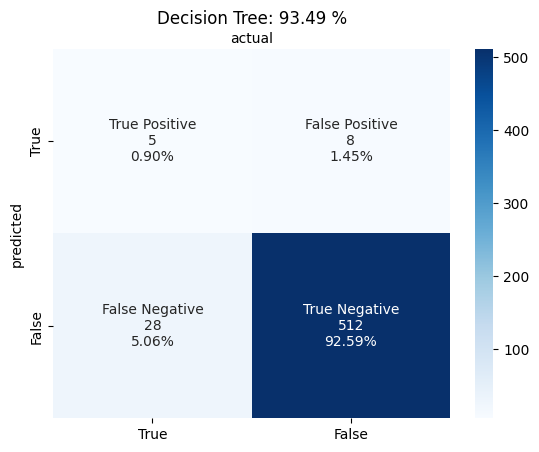

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.384615 |
+-------------+----------+
| Recall      | 0.151515 |
+-------------+----------+
| Specificity | 0.984615 |
+-------------+----------+
| F1 Score    | 0.217391 |
+-------------+----------+
| ROC-AUC     | 0.568065 |
+-------------+----------+
| Accuracy    | 0.934901 |
+-------------+----------+
2) Model Name: Random Forest


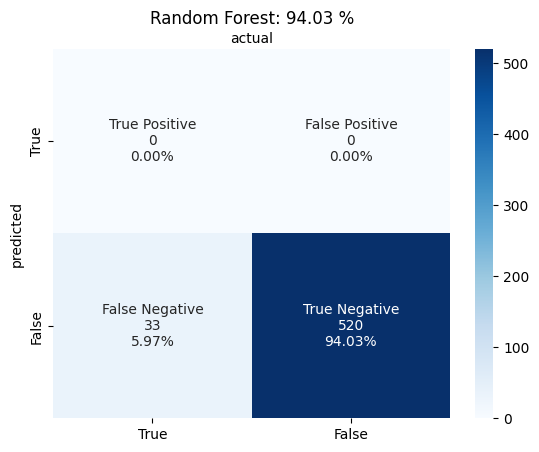

c:\Users\Study\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0        |
+-------------+----------+
| Recall      | 0        |
+-------------+----------+
| Specificity | 1        |
+-------------+----------+
| F1 Score    | 0        |
+-------------+----------+
| ROC-AUC     | 0.5      |
+-------------+----------+
| Accuracy    | 0.940325 |
+-------------+----------+
3) Model Name: K Nearest Neighbour


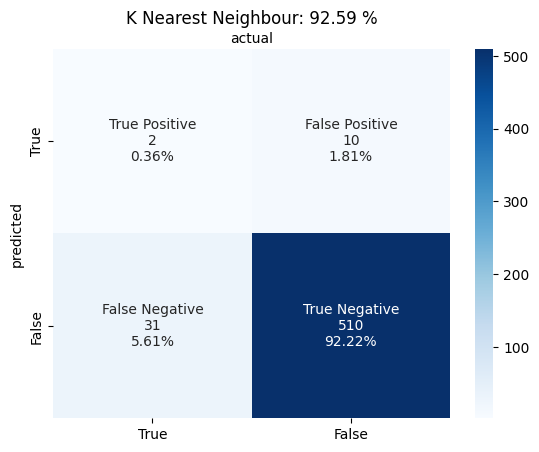

+-------------+-----------+
| Metric      |     Value |
+=============+===========+
| Precision   | 0.166667  |
+-------------+-----------+
| Recall      | 0.0606061 |
+-------------+-----------+
| Specificity | 0.980769  |
+-------------+-----------+
| F1 Score    | 0.0888889 |
+-------------+-----------+
| ROC-AUC     | 0.520688  |
+-------------+-----------+
| Accuracy    | 0.925859  |
+-------------+-----------+
4) Model Name: Adaptive Boosting


c:\Users\Study\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


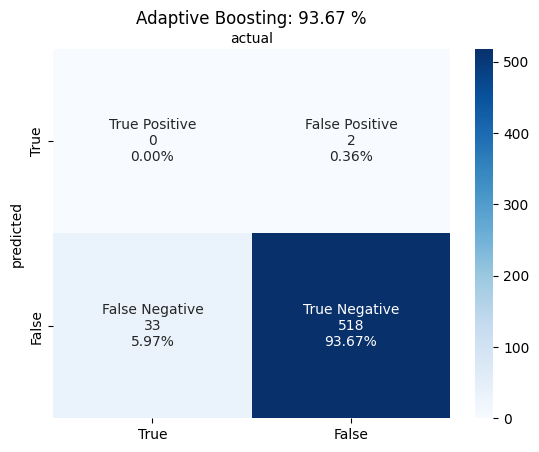

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0        |
+-------------+----------+
| Recall      | 0        |
+-------------+----------+
| Specificity | 0.996154 |
+-------------+----------+
| F1 Score    | 0        |
+-------------+----------+
| ROC-AUC     | 0.498077 |
+-------------+----------+
| Accuracy    | 0.936709 |
+-------------+----------+
5) Model Name: Extreme Gradient Boosting


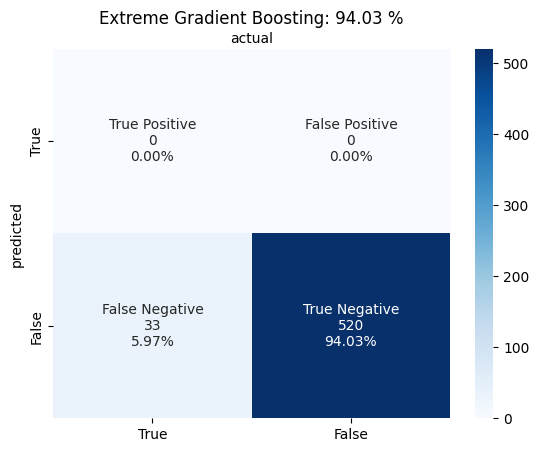

c:\Users\Study\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0        |
+-------------+----------+
| Recall      | 0        |
+-------------+----------+
| Specificity | 1        |
+-------------+----------+
| F1 Score    | 0        |
+-------------+----------+
| ROC-AUC     | 0.5      |
+-------------+----------+
| Accuracy    | 0.940325 |
+-------------+----------+
6) Model Name: Voting Classifier


c:\Users\Study\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


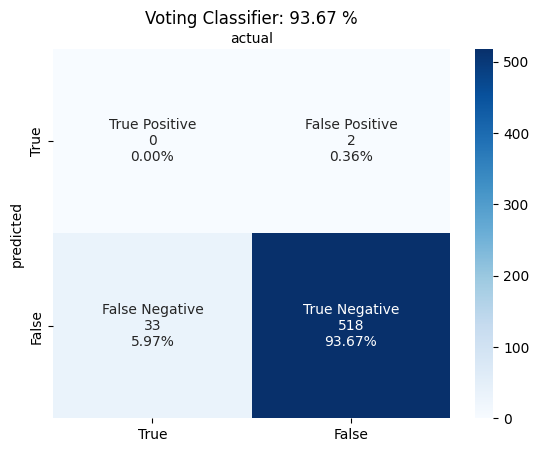

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0        |
+-------------+----------+
| Recall      | 0        |
+-------------+----------+
| Specificity | 0.996154 |
+-------------+----------+
| F1 Score    | 0        |
+-------------+----------+
| ROC-AUC     | 0.498077 |
+-------------+----------+
| Accuracy    | 0.936709 |
+-------------+----------+


In [8]:
def train_and_test_models(models, model_names, X_training=X_train, y_training=y_train):
    model_metrics = []
    for i, model in enumerate(models):
        print(f"{i+1}) Model Name: {model_names[i]}")
        model.fit(X_training, y_training)
        model_pred = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, model_pred)
        order = visualize_cf(model_pred, model_names[i],accuracy)
        metric = calc_metrics(model_pred, order)
        model_metrics.append(metric)
    return model_metrics

actual_metrics = train_and_test_models(models, model_names)

### 5.4. Oversampling 

As only 6.3% of the overall dataset consists of patients diagnosed with dementia, we will now make a SMOTEomic oversampling on the target feature. Oversampling using SMOTE and Tomelink - <font color = yellow> skriv noget mere her </font>. Vi starter med SMOTE 


In [9]:
print(Counter(y_train))
smo = SMOTE(sampling_strategy=0.7)
X_S, y_S = smo.fit_resample(X_train, y_train)
print(Counter(y_S))

Counter({0: 1206, 1: 83})
Counter({0: 1206, 1: 844})


1) Model Name: Decision Tree


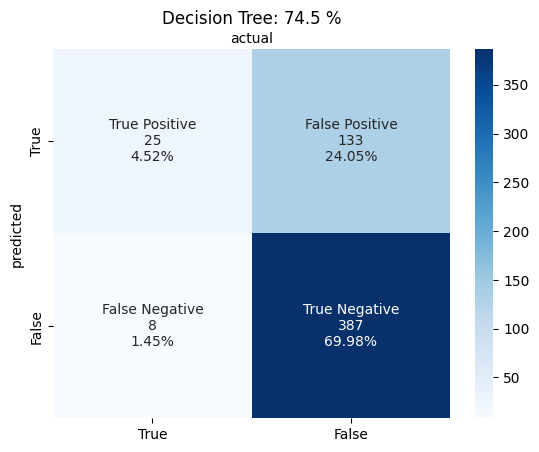

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.158228 |
+-------------+----------+
| Recall      | 0.757576 |
+-------------+----------+
| Specificity | 0.744231 |
+-------------+----------+
| F1 Score    | 0.26178  |
+-------------+----------+
| ROC-AUC     | 0.750903 |
+-------------+----------+
| Accuracy    | 0.745027 |
+-------------+----------+
2) Model Name: Random Forest


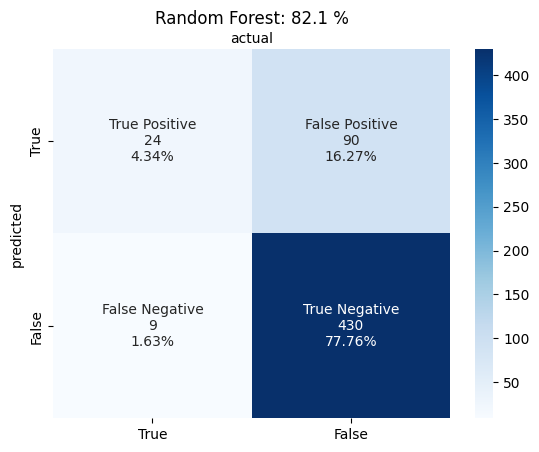

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.210526 |
+-------------+----------+
| Recall      | 0.727273 |
+-------------+----------+
| Specificity | 0.826923 |
+-------------+----------+
| F1 Score    | 0.326531 |
+-------------+----------+
| ROC-AUC     | 0.777098 |
+-------------+----------+
| Accuracy    | 0.820976 |
+-------------+----------+
3) Model Name: K Nearest Neighbour


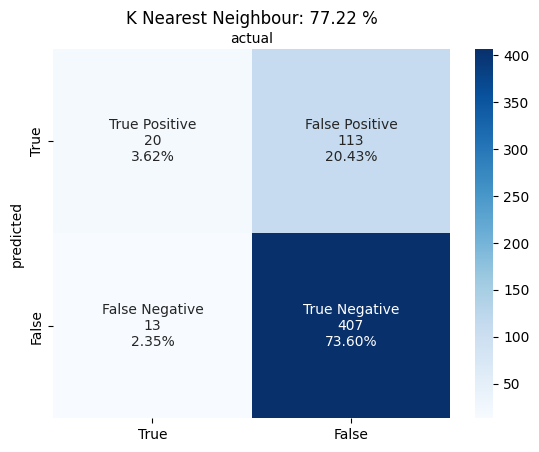

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.150376 |
+-------------+----------+
| Recall      | 0.606061 |
+-------------+----------+
| Specificity | 0.782692 |
+-------------+----------+
| F1 Score    | 0.240964 |
+-------------+----------+
| ROC-AUC     | 0.694376 |
+-------------+----------+
| Accuracy    | 0.772152 |
+-------------+----------+
4) Model Name: Adaptive Boosting


c:\Users\Study\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


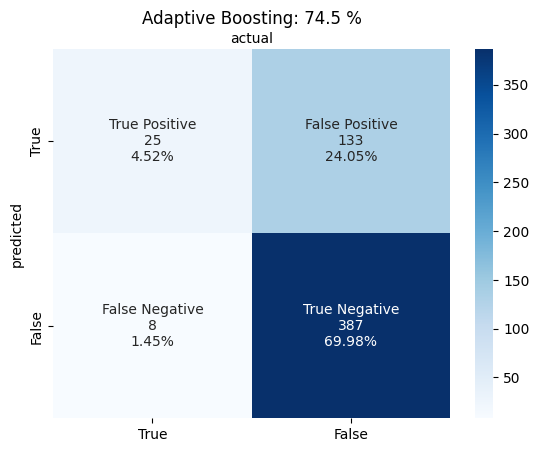

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.158228 |
+-------------+----------+
| Recall      | 0.757576 |
+-------------+----------+
| Specificity | 0.744231 |
+-------------+----------+
| F1 Score    | 0.26178  |
+-------------+----------+
| ROC-AUC     | 0.750903 |
+-------------+----------+
| Accuracy    | 0.745027 |
+-------------+----------+
5) Model Name: Extreme Gradient Boosting


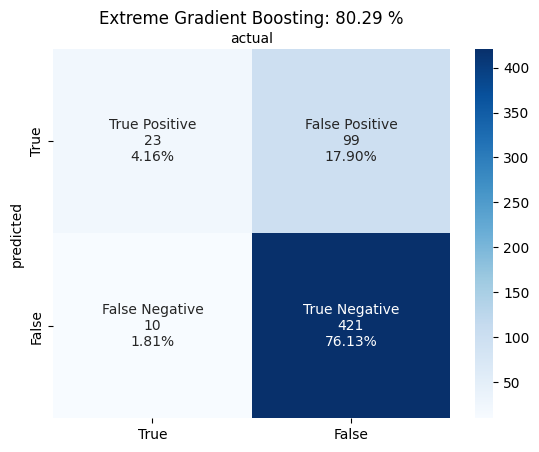

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.188525 |
+-------------+----------+
| Recall      | 0.69697  |
+-------------+----------+
| Specificity | 0.809615 |
+-------------+----------+
| F1 Score    | 0.296774 |
+-------------+----------+
| ROC-AUC     | 0.753293 |
+-------------+----------+
| Accuracy    | 0.802893 |
+-------------+----------+
6) Model Name: Voting Classifier


c:\Users\Study\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


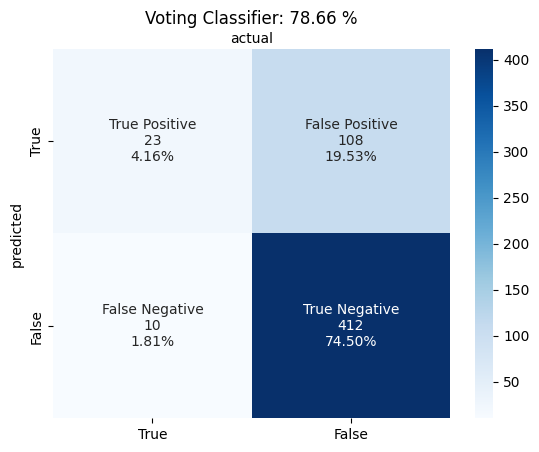

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.175573 |
+-------------+----------+
| Recall      | 0.69697  |
+-------------+----------+
| Specificity | 0.792308 |
+-------------+----------+
| F1 Score    | 0.280488 |
+-------------+----------+
| ROC-AUC     | 0.744639 |
+-------------+----------+
| Accuracy    | 0.786618 |
+-------------+----------+


In [10]:
SMOTE_metrics = train_and_test_models(models, model_names, X_S, y_S)

### 5.5. SMOTE+TOMEK


In [11]:
print(Counter(y_train))
smo_tomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')) 
X_ST, y_ST = smo_tomek.fit_resample(X_train, y_train)
print(Counter(y_ST))

Counter({0: 1206, 1: 83})
Counter({1: 1206, 0: 1193})


1) Model Name: Decision Tree


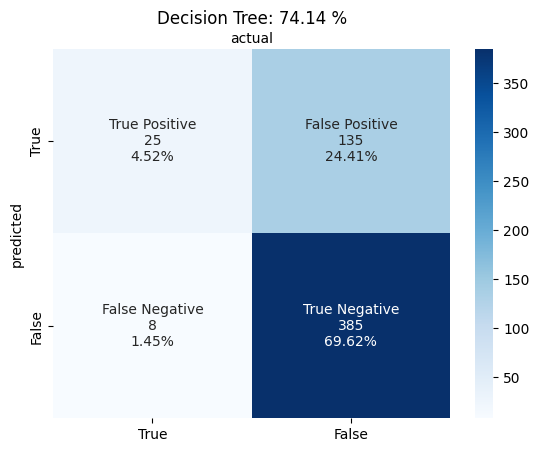

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.15625  |
+-------------+----------+
| Recall      | 0.757576 |
+-------------+----------+
| Specificity | 0.740385 |
+-------------+----------+
| F1 Score    | 0.259067 |
+-------------+----------+
| ROC-AUC     | 0.74898  |
+-------------+----------+
| Accuracy    | 0.74141  |
+-------------+----------+
2) Model Name: Random Forest


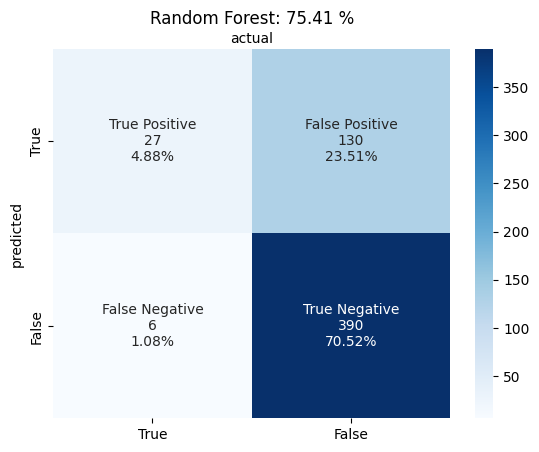

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.171975 |
+-------------+----------+
| Recall      | 0.818182 |
+-------------+----------+
| Specificity | 0.75     |
+-------------+----------+
| F1 Score    | 0.284211 |
+-------------+----------+
| ROC-AUC     | 0.784091 |
+-------------+----------+
| Accuracy    | 0.754069 |
+-------------+----------+
3) Model Name: K Nearest Neighbour


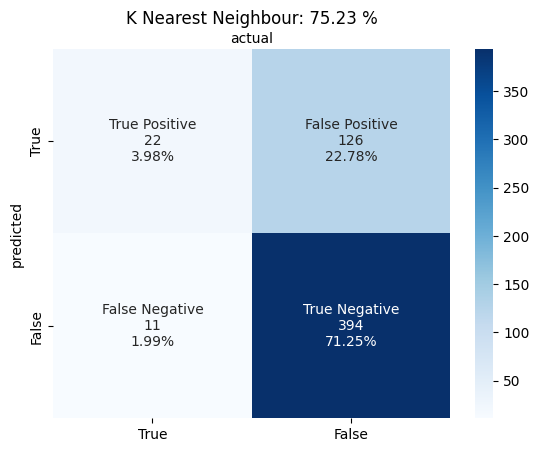

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.148649 |
+-------------+----------+
| Recall      | 0.666667 |
+-------------+----------+
| Specificity | 0.757692 |
+-------------+----------+
| F1 Score    | 0.243094 |
+-------------+----------+
| ROC-AUC     | 0.712179 |
+-------------+----------+
| Accuracy    | 0.75226  |
+-------------+----------+
4) Model Name: Adaptive Boosting


c:\Users\Study\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


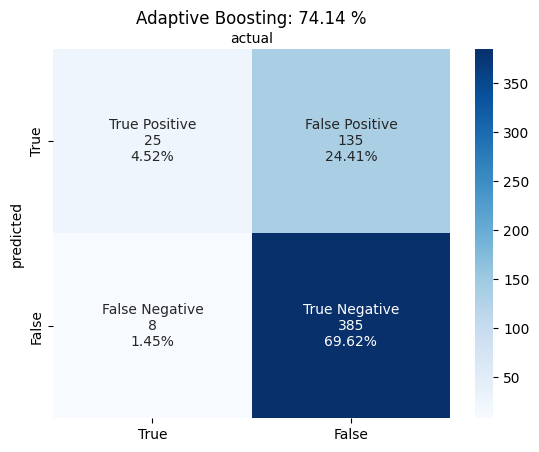

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.15625  |
+-------------+----------+
| Recall      | 0.757576 |
+-------------+----------+
| Specificity | 0.740385 |
+-------------+----------+
| F1 Score    | 0.259067 |
+-------------+----------+
| ROC-AUC     | 0.74898  |
+-------------+----------+
| Accuracy    | 0.74141  |
+-------------+----------+
5) Model Name: Extreme Gradient Boosting


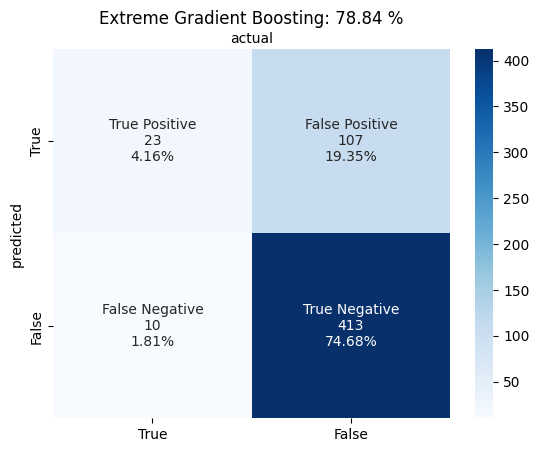

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.176923 |
+-------------+----------+
| Recall      | 0.69697  |
+-------------+----------+
| Specificity | 0.794231 |
+-------------+----------+
| F1 Score    | 0.282209 |
+-------------+----------+
| ROC-AUC     | 0.7456   |
+-------------+----------+
| Accuracy    | 0.788427 |
+-------------+----------+
6) Model Name: Voting Classifier


c:\Users\Study\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


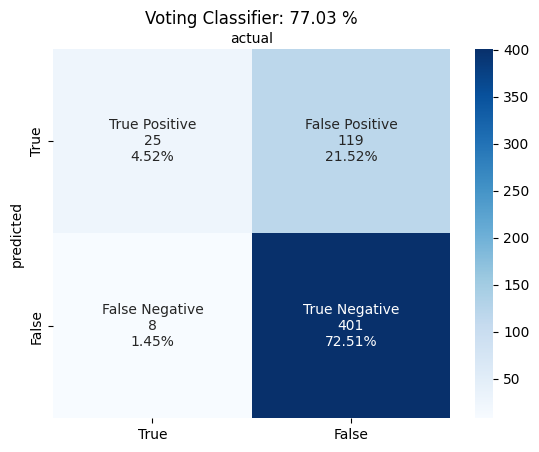

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.173611 |
+-------------+----------+
| Recall      | 0.757576 |
+-------------+----------+
| Specificity | 0.771154 |
+-------------+----------+
| F1 Score    | 0.282486 |
+-------------+----------+
| ROC-AUC     | 0.764365 |
+-------------+----------+
| Accuracy    | 0.770344 |
+-------------+----------+


In [12]:
smo_tomek_metrics = train_and_test_models(models, model_names, X_ST, y_ST)

### 5.6. K-fold

#### Mapping from models to classifier names In order to adjust hyper parameters using gridsearch

In [13]:
CLASSIFIER_MAPPING = {
    models[0]: 'decisiontreeclassifier',
    models[1]: 'randomforestclassifier',
    models[2]: 'baggingclassifier',
    models[3]: 'adaboostclassifier',
    models[4]: 'xgbclassifier',
    models[5]: 'votingclassifier'
}

MODEL_CONSTRUCTORS = {
    models[0]: DecisionTreeClassifier,
    models[1]: RandomForestClassifier,
    models[2]: BaggingClassifier,
    models[3]: AdaBoostClassifier,
    models[4]: XGBClassifier,
    models[5]: VotingClassifier
}

#### Define mapping of parameters and hyper parameters to be tweaked for each model with gridsearchcv

In [14]:
def frange(start, stop, fraction):
    return [x/fraction for x in range(start,stop)]

dct_params = {
    'max_depth': range(2, 10)
}

rfc_params = {
    'n_estimators': range(5,100,5),
    'max_depth': range(1, 9)
}

bac_params = {
    'n_estimators': [10, 50, 100],
}

ada_params = {
    'n_estimators': [50, 100, 200]
}

bst_params = {
    'n_estimators': range(1,20),
    'max_depth': range(2, 4),
    'learning_rate': frange(0,3, 10),
    'subsample': frange(5, 11, 10),
    'colsample_bytree': frange(5, 11, 10)
}

vcl_params = {
    'estimators': [estimators],  # List of (name, estimator) tuples
    'voting': ['hard', 'soft'],
    'weights': [[1, 1], [2, 1], [1, 2]]  # Weights for soft voting
}

model_params = {    
    models[0]: dct_params,
    models[1]: rfc_params,
    models[2]: bac_params,
    models[3]: ada_params,
    models[4]: bst_params,
    models[5]: vcl_params
}

#### K-fold for tuning of hyper parameters and a safe method incase of errors 

In [15]:
from imblearn.pipeline import Pipeline, make_pipeline

def specificity_score(y_true, y_pred):
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

SCORING_METRICS = {
    'precision_score': 'precision',
    'recall_score': 'recall',
    'specificity_score': metrics.make_scorer(specificity_score), 
    'f1_score': 'f1',
    'roc_auc_score': 'roc_auc',
    'accuracy_score': 'accuracy'
}

def k_fold(model, X_training=X_train, y_Training=y_train, num_folds=5, hyperparameter_tuning=False):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    k_fold_metrics = []
    
    VCL_INDEX = 5 # to remedy error: "VotingClassifier has none of the following attributes: decision_function, predict_proba.""
    try: 
        if VCL_INDEX == models.index(model):
            raise TypeError("VotingClassifier cannot cross_validate")
        oversampler = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')) 
        imba_pipeline = make_pipeline(oversampler, model) 
        if hyperparameter_tuning:
            model_param = model_params[model]
            classifier_name = CLASSIFIER_MAPPING[model]
            new_params = {classifier_name + '__'  + key : model_param[key] for key in model_param}
            grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring=SCORING_METRICS, refit='recall_score', return_train_score=True)
            grid_imba.fit(X_training, y_Training)

            prefix_to_remove = classifier_name + '__'
            best_params = {key[len(prefix_to_remove):]: value for key, value in grid_imba.best_params_.items()}
            imba_pipeline = make_pipeline(oversampler, (MODEL_CONSTRUCTORS.get(model)(**best_params))) # overwrite model using best parameters
        cross_val_results = cross_validate(imba_pipeline, X_training, y_Training, cv=kf, scoring = SCORING_METRICS)
    except Exception as _:
        return k_fold_deprecated(model, X_training, y_Training, num_folds)
     
    IRRELEVANT_SCORES = ['fit_time', 'score_time']
    for test_score in cross_val_results:
        if IRRELEVANT_SCORES.__contains__(test_score): # Remove unnessary scores 
            continue
    
        k_fold_metrics.append(cross_val_results[test_score].mean())
        
    return k_fold_metrics

def k_fold_deprecated(model, X_training=X_train, y_Training=y_train, num_folds=5):
    k_fold_metrics = []
    i = models.index(model)
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    oversampler = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')) 

    for _, (train_index, test_index) in enumerate(kf.split(X_training, y_Training)):
        k_X_train, k_X_test = X_training.iloc[train_index], X_training.iloc[test_index]
        k_y_train, k_y_test = y_Training[train_index], y_Training[test_index]

        X_train_fold_upsample, y_train_fold_upsample = oversampler.fit_resample(k_X_train, k_y_train)

        model.fit(X_train_fold_upsample, y_train_fold_upsample)
        model_pred = model.predict(k_X_test)
        i = models.index(model)
        accuracy = metrics.accuracy_score(k_y_test, model_pred)
        order = visualize_cf(model_pred, model_names[i], accuracy, k_y_test)
        metric = calc_metrics(model_pred, order, k_y_test)
        k_fold_metrics.append(metric)

    NUMBER_OF_METRICS = len(SCORING_METRICS)
    flip_arr = np.array((k_fold_metrics)).T.reshape(NUMBER_OF_METRICS, num_folds)
    k_fold_metrics_mean = [metric.mean() for metric in flip_arr]
    return k_fold_metrics_mean



#### Evaluate models using k_fold

c:\Users\Study\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Study\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Study\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Study\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is 

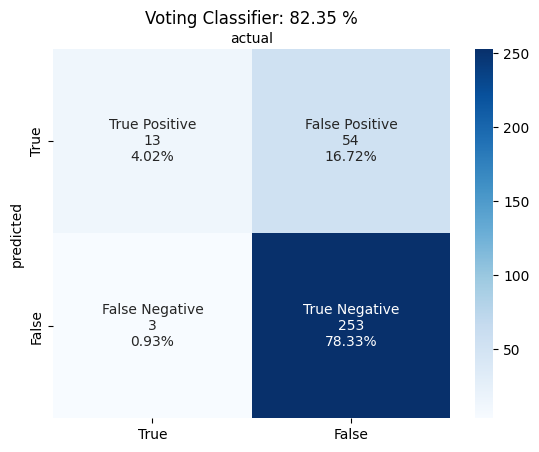

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.19403  |
+-------------+----------+
| Recall      | 0.8125   |
+-------------+----------+
| Specificity | 0.824104 |
+-------------+----------+
| F1 Score    | 0.313253 |
+-------------+----------+
| ROC-AUC     | 0.818302 |
+-------------+----------+
| Accuracy    | 0.823529 |
+-------------+----------+


c:\Users\Study\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


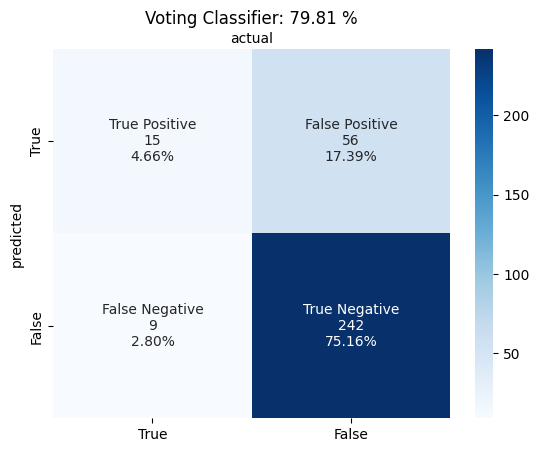

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.211268 |
+-------------+----------+
| Recall      | 0.625    |
+-------------+----------+
| Specificity | 0.812081 |
+-------------+----------+
| F1 Score    | 0.315789 |
+-------------+----------+
| ROC-AUC     | 0.71854  |
+-------------+----------+
| Accuracy    | 0.798137 |
+-------------+----------+


c:\Users\Study\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


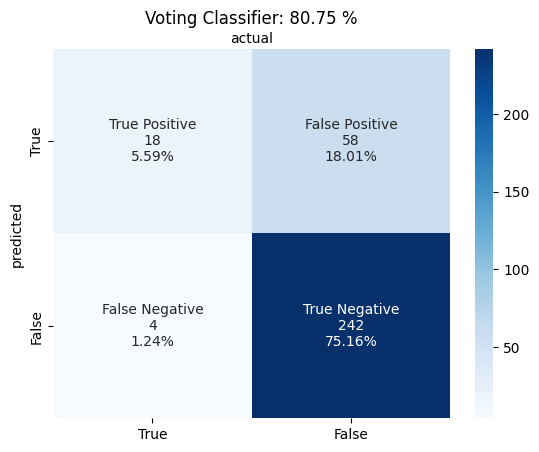

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.236842 |
+-------------+----------+
| Recall      | 0.818182 |
+-------------+----------+
| Specificity | 0.806667 |
+-------------+----------+
| F1 Score    | 0.367347 |
+-------------+----------+
| ROC-AUC     | 0.812424 |
+-------------+----------+
| Accuracy    | 0.807453 |
+-------------+----------+


c:\Users\Study\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


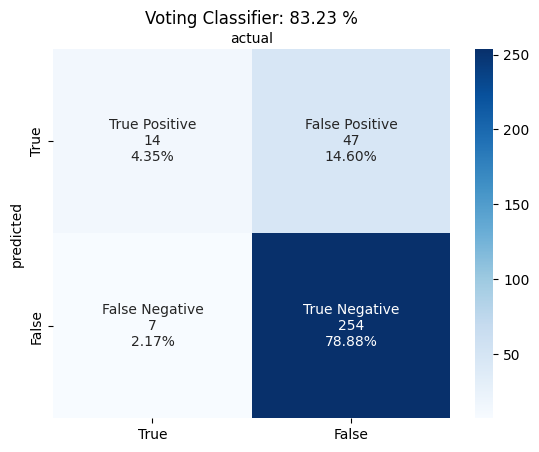

+-------------+----------+
| Metric      |    Value |
+=============+==========+
| Precision   | 0.229508 |
+-------------+----------+
| Recall      | 0.666667 |
+-------------+----------+
| Specificity | 0.843854 |
+-------------+----------+
| F1 Score    | 0.341463 |
+-------------+----------+
| ROC-AUC     | 0.75526  |
+-------------+----------+
| Accuracy    | 0.832298 |
+-------------+----------+


In [16]:
k_fold_metrics = []

for i, model in enumerate(models):
    evaluation_metrics = k_fold(model, num_folds=4)
    k_fold_metrics.append(evaluation_metrics)

### 5.7. Comparative analysis of metrics

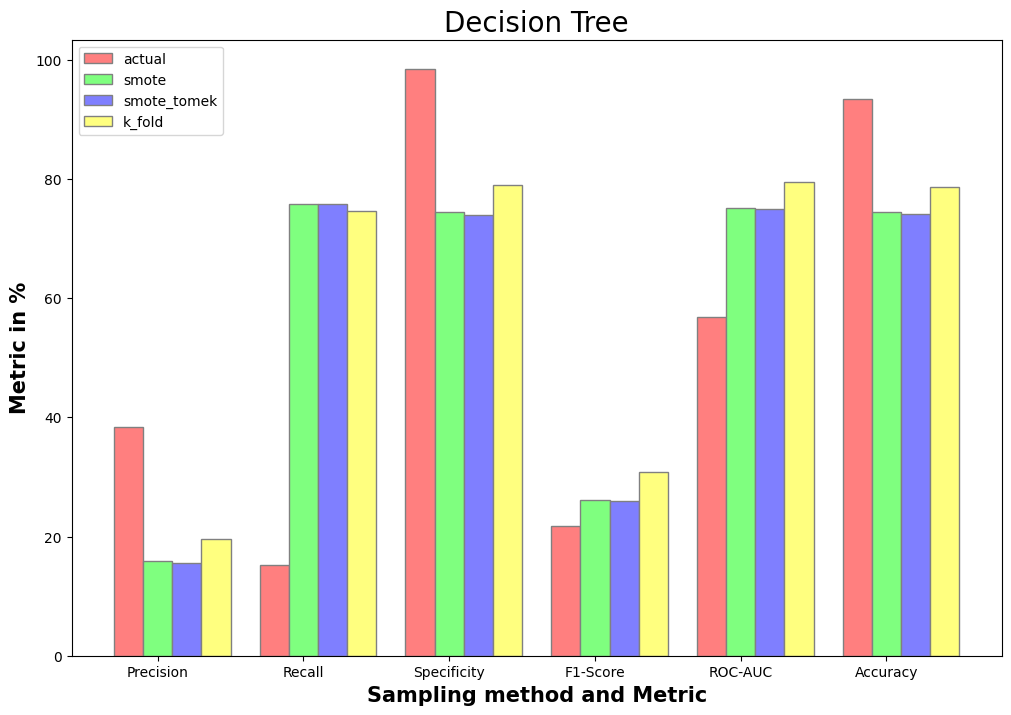

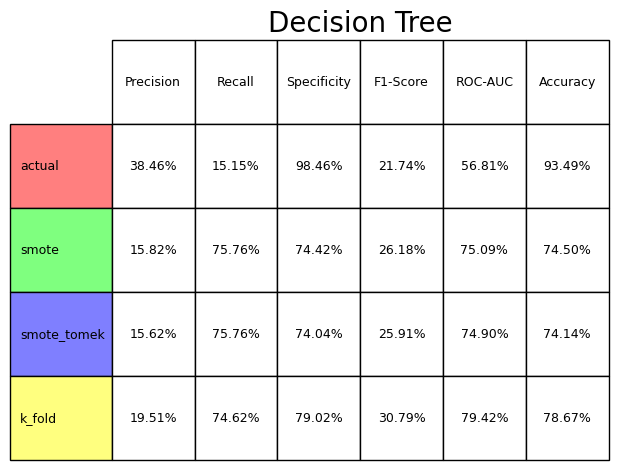

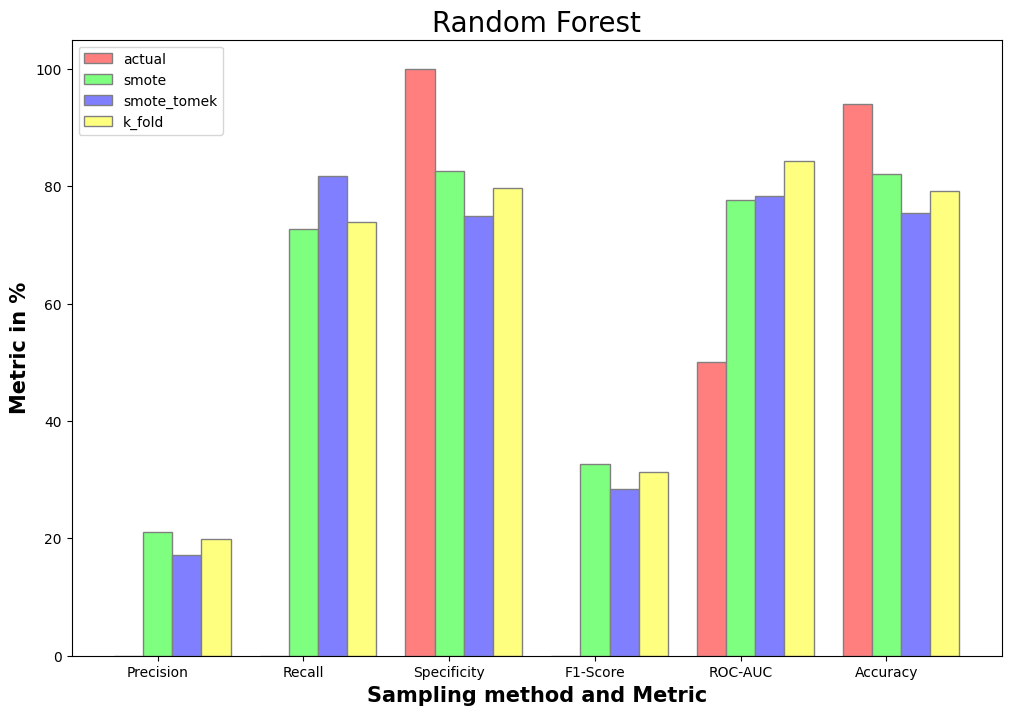

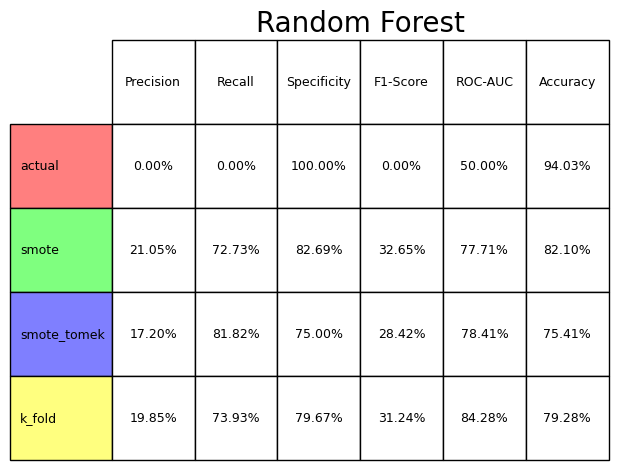

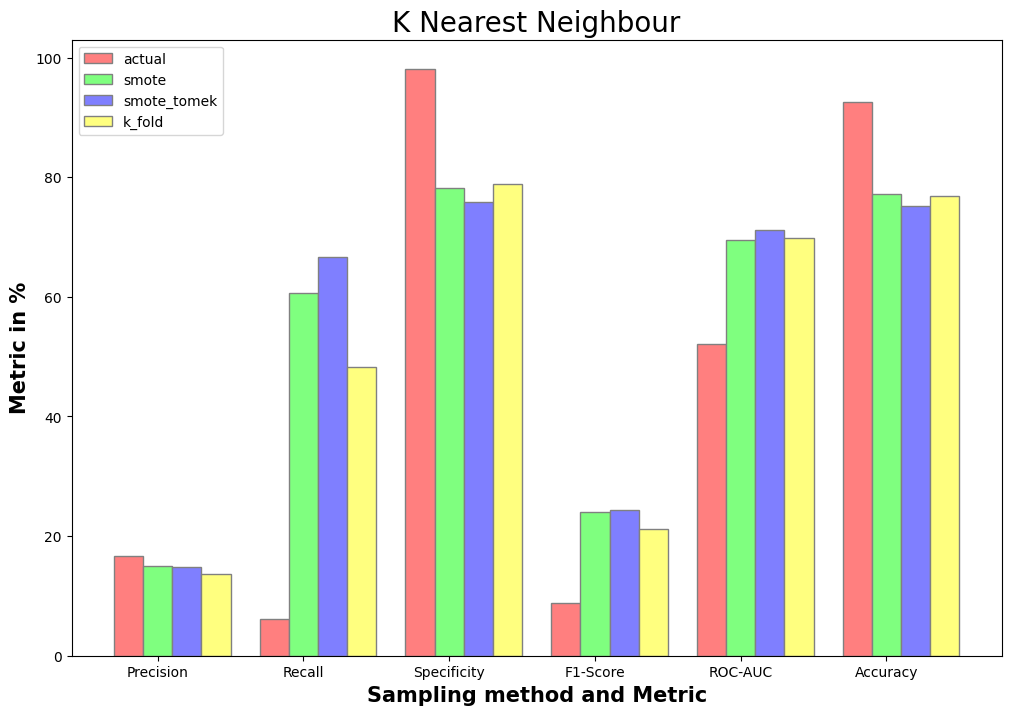

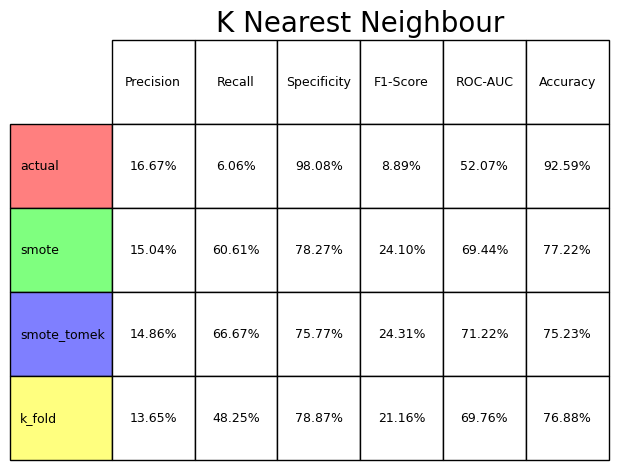

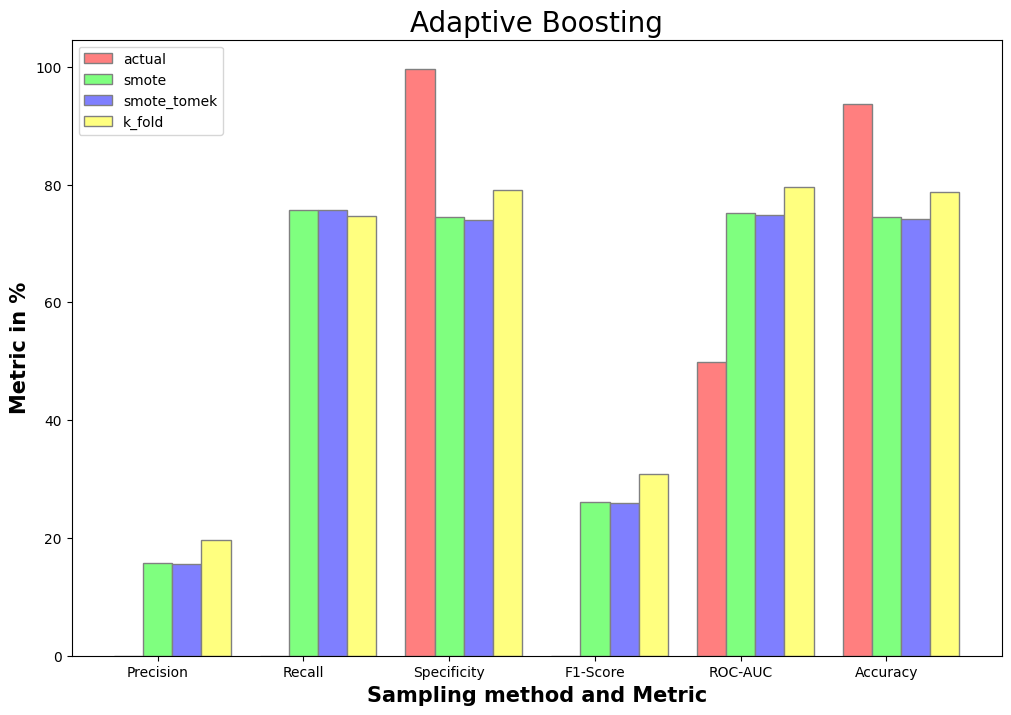

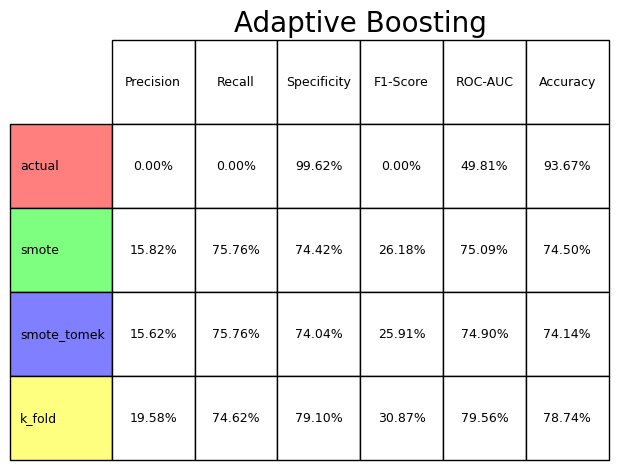

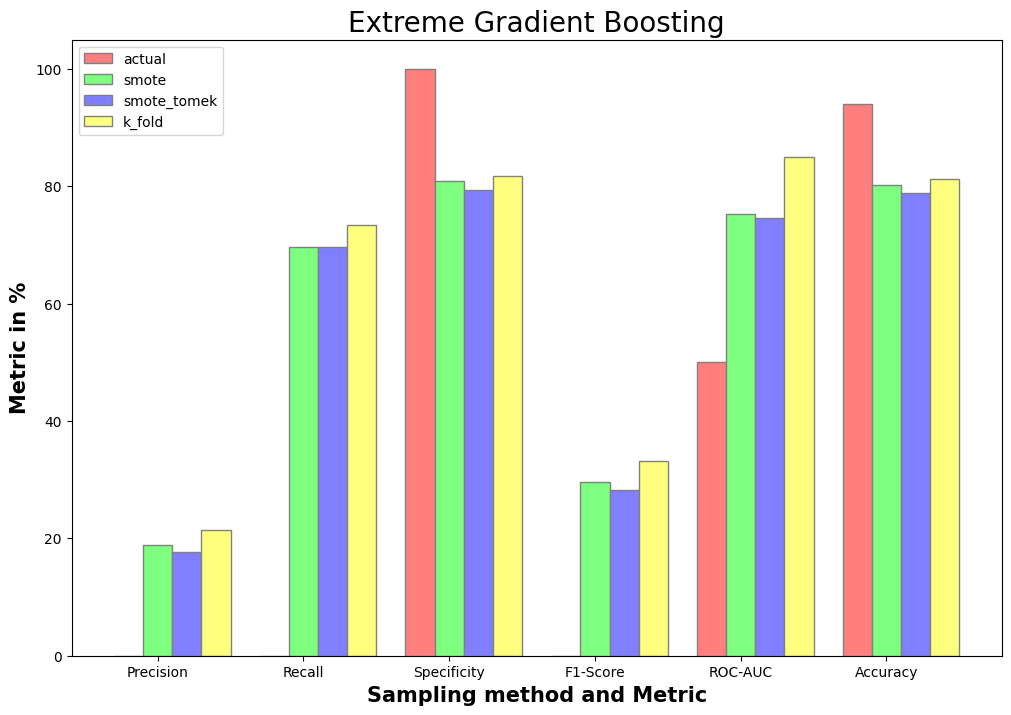

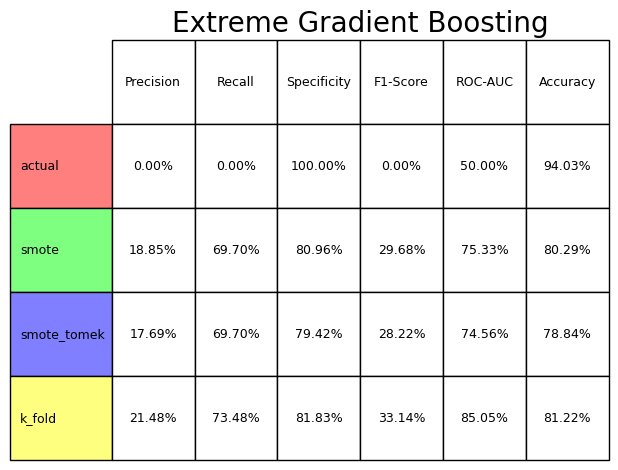

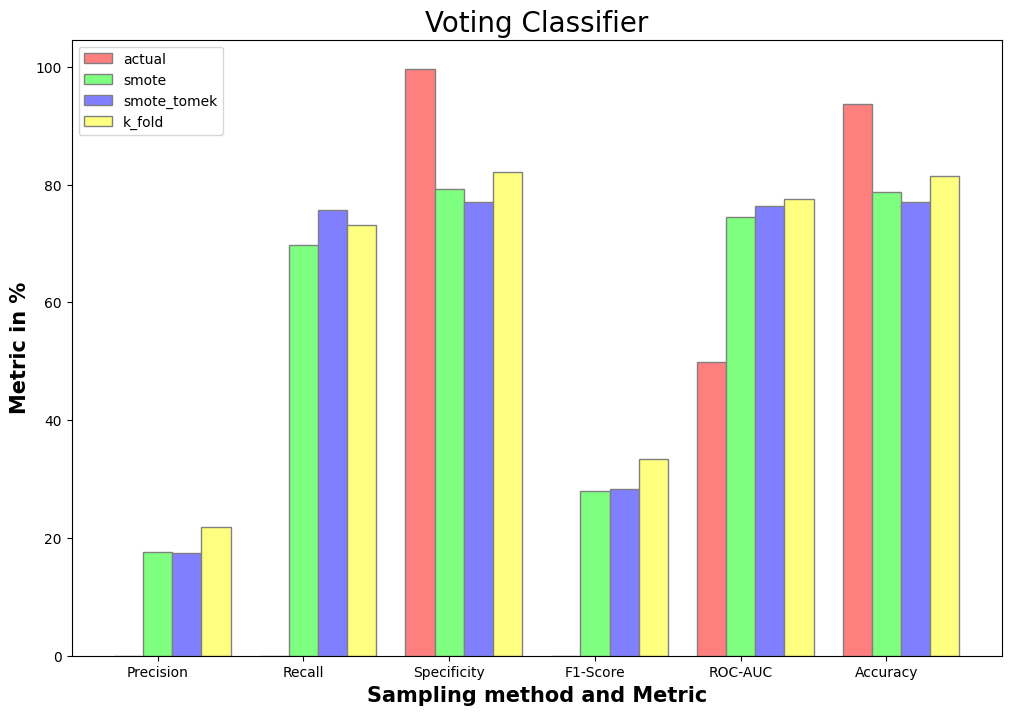

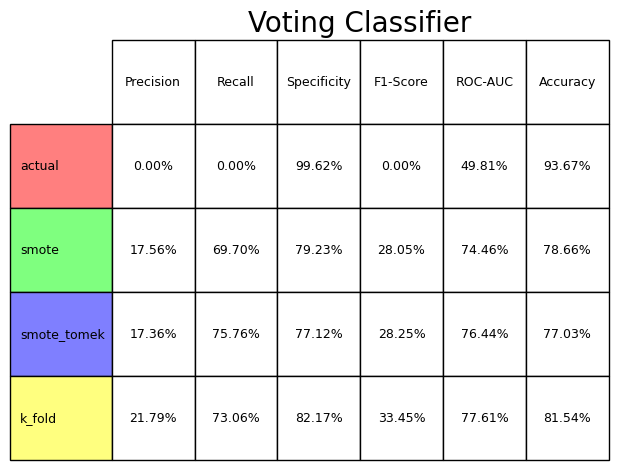

In [17]:
img_folder = "img/"
BAR_PLOT_FOLDER = img_folder + "bar/"
TABLE_PLOT_FOLDER = img_folder + "table/"
NUMBER_OF_METHODS = 4
SAMPLING_METHOD_COLOURS = ['#ff7f7f',  '#7fff7f', '#7f7fff', '#ffff7f'] # soft: red, green , blue ,yellow

def comparative_analysis(model, model_name):

    index = models.index(model)
    model_metrics = []
    model_metrics.append(actual_metrics[index])
    model_metrics.append(SMOTE_metrics[index])
    model_metrics.append(smo_tomek_metrics[index])
    model_metrics.append(k_fold_metrics[index])

    columns = ["Precision", "Recall", "Specificity", "F1-Score", "ROC-AUC", "Accuracy"] 
    rows = ['actual', 'smote', 'smote_tomek', 'k_fold']

    # create stacked bar plot
    create_bar_plot(model_name, model_metrics, rows, columns, SAMPLING_METHOD_COLOURS)

    _, ax = plt.subplots()
    cell_text = []
    DECIMAL_PLACES = 2
    for row in range(NUMBER_OF_METHODS):
        cell_text.append(['{:.{}f}%'.format(x * 100, DECIMAL_PLACES) for x in model_metrics[row]])

    plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=SAMPLING_METHOD_COLOURS,
                      colLabels=columns,
                      # cellColours=[softened_colors] * (len(rows)),
                      loc='center',
                      cellLoc='center',
                      bbox=[0, 0, 1, 1])

    ax.axis('off')
    plt.xticks([])
    plt.title(model_name, fontsize=20)
    plt.tight_layout()
    plt.savefig(TABLE_PLOT_FOLDER + "eval_metrics_" + model_name, bbox_inches='tight')
    plt.show()

def create_bar_plot(model_name, data, rows, columns, colors = ['r','g','b','y']):
    # set width of bar 
    barWidth = 0.2
    plt.subplots(figsize =(12, 8)) 
    
    # Set position of bar on X axis 
    bar_positions = [np.arange(len(data[0]))] # intial bar position
    for i in range(0, len(rows)):
        bar_positions.append([x + barWidth for x in bar_positions[i]])

    # Make the plot
    for i in range(len(rows)):
        plt.bar(bar_positions[i], convert_to_percantage(data[i]), color = colors[i], width = barWidth, edgecolor ='grey', label = rows[i]) 

    # Adding Xticks 
    plt.xlabel('Sampling method and Metric', fontweight ='bold', fontsize = 15) 
    plt.ylabel('Metric in %', fontweight ='bold', fontsize = 15) 
    plt.xticks([r + barWidth for r in range(len(columns))], columns)
    plt.title(model_name, fontsize=20)
    plt.legend()
    plt.savefig(BAR_PLOT_FOLDER + "bar_metrics_" + model_name, bbox_inches='tight')

    plt.show()

def convert_to_percantage(metrics):
    return [metric * 100 for metric in metrics]


PRINT_FIGS = True
for (model, model_name) in list(zip(models, model_names)):
    if PRINT_FIGS: 
        comparative_analysis(model, model_name)
    
